# Visualise GWAS output

## Patristic distances

In [64]:
library(readr)

# Construct the file path using environment variable
genomics_data_base <- Sys.getenv("GENOMICS_DATA_BASE")
file_path <- file.path(genomics_data_base, "annotations", "e_coli", "gene_sequences", "fhub_gene", "mortality_snps.plot")

# Read the file, skipping comment lines
plot.df <- read_tsv(
  file_path,
  comment = "#",
  col_names = c("CHR", "SNP", "BP", "minLOG10_p", "log10_p", "r2")
)

plot.df$p <- 10^(-plot.df$log10_p)
plot.df$SNP <- paste(plot.df$CHR, plot.df$BP, sep = "_")

head(plot.df)

Rows: 16 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): SNP
dbl (5): CHR, BP, minLOG10_p, log10_p, r2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


CHR,SNP,BP,minLOG10_p,log10_p,r2,p
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1_592,592,0.5816990,0.5816990,0,0.261999824
1,1_619,619,0.4329740,0.4329740,0,0.368999689
1,1_630,630,0.0604807,0.0604807,0,0.870000095
1,1_672,672,0.5606670,0.5606670,0,0.275000194
1,1_723,723,2.6420700,2.6420700,0,0.002279975
1,1_828,828,2.4389000,2.4389000,0,0.003639988


In [65]:
# Bonferroni correction

p.value.cutoff = -log10(0.05/nrow(plot.df))
p.value.cutoff

[1] 2.50515

In [66]:
# Assuming you have a vector of p-values called 'p_values'
# and a desired significance level 'alpha'
p_values <- plot.df$p
alpha <- 0.05

# Use the p.adjust function with method=["bonferroni", "holm", "hochberg", "hommel", "BH", "BY"]
adjusted_p_values <- p.adjust(p_values, method = "holm")

# Compare adjusted p-values with alpha
significant <- adjusted_p_values < alpha

signif.snps <- plot.df$SNP[significant]

signif.snps
# length(signif.snps)
# print(length(signif.snps))
# print(adjusted_p_values)

[1] "1_723"

ERROR: Error in manhattan(plot.df, chr = "CHR", bp = "BP", snp = "SNP", p = "p", : non-numeric argument to binary operator


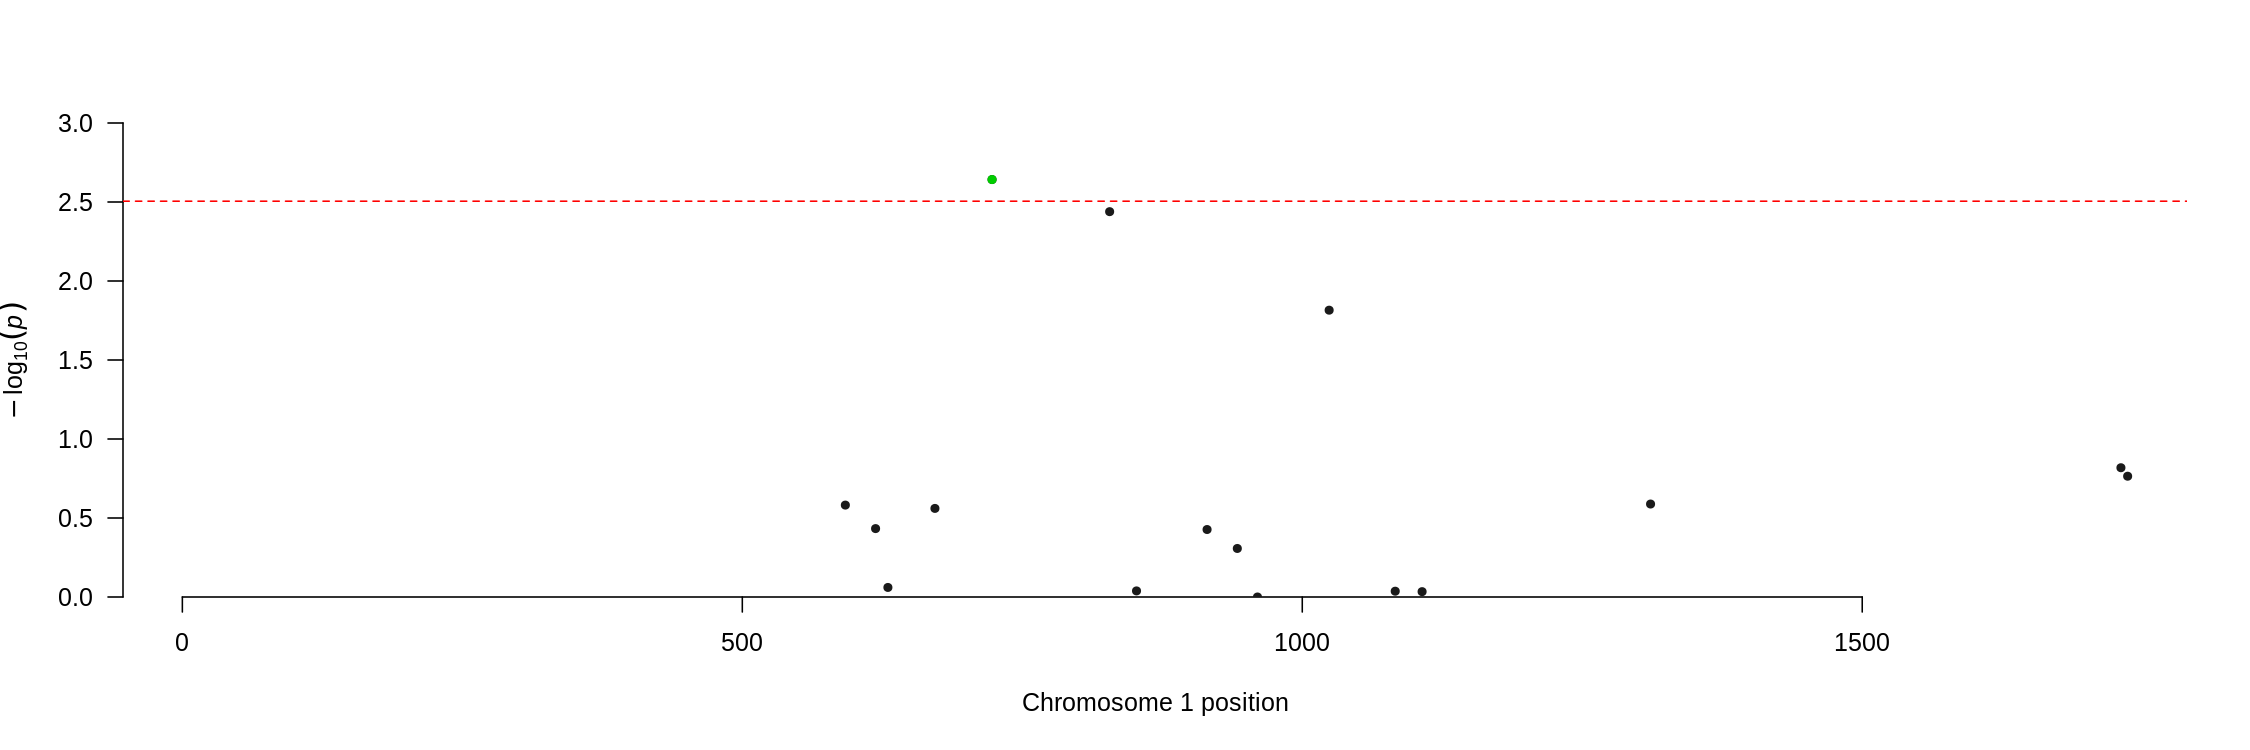

In [67]:
library(qqman)


options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 150)
par(bg = "white")
manhattan(
    plot.df,
    chr="CHR",
    bp="BP",
    snp="SNP",
    p="p",
    # logp=FALSE,
    highlight = signif.snps
    ) +
    abline(h = p.value.cutoff, col = "red", lty = 2)

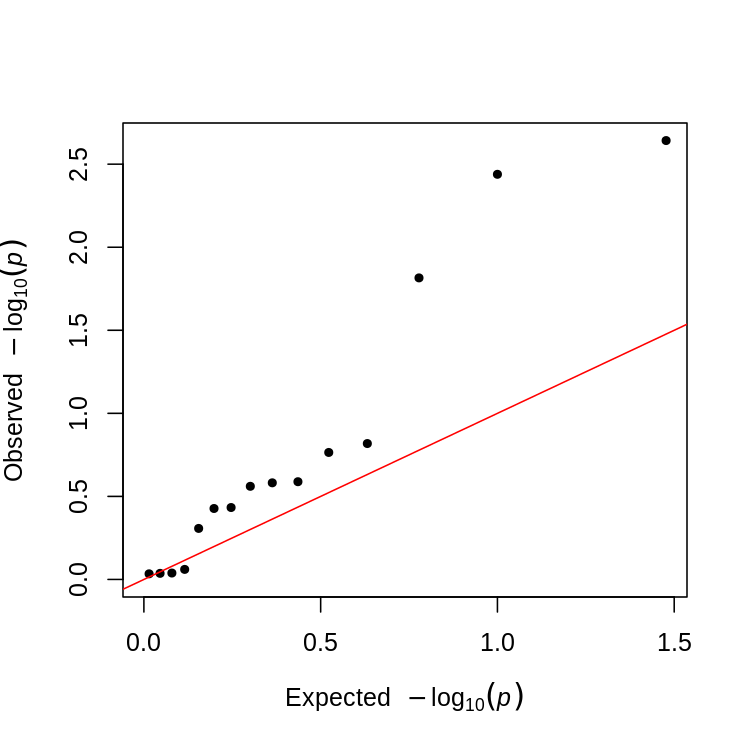

In [68]:
library(qqman)


options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 150)
par(bg = "white")
qq(plot.df$p)

In [69]:
chisq_vals <- qchisq(1 - plot.df$p, df = 1)
lambda <- median(chisq_vals) / qchisq(0.5, df = 1)
print(paste("Genomic inflation factor (λ):", round(lambda, 3)))

[1] "Genomic inflation factor (λ): 2.197"


## Distance from root

### Count the number of patterns to control for multiple testing

In [ ]:
python ~/workspace/pyseer/scripts/count_patterns.py mortality_SNP_patterns.txt

Output:

Patterns:	98

Threshold:	5.10E-04

In [ ]:
library(data.table)


gono_gwas <- fread('~/workspace/genome_data/annotations/e_coli/gene_sequences/fhub_gene/mortality_SNPs_lmm.txt', data.table = FALSE)
head(gono_gwas)

,variant,af,filter-pvalue,lrt-pvalue,beta,beta-std-err,variant_h2,notes
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,1_592_T_C,0.841,0.9620,0.565,-0.02380,0.0413,0.01990,NA
2,1_619_C_T,0.805,0.7870,0.893,-0.00574,0.0425,0.00466,NA
3,1_630_T_C,0.810,0.6580,0.892,0.00573,0.0422,0.00468,NA
4,1_672_C_T,0.882,0.0661,0.117,0.07710,0.0491,0.05410,NA
5,1_696_G_T,0.740,0.8710,0.917,-0.00398,0.0381,0.00361,NA
6,1_709_C_T,0.779,0.7390,0.964,0.00193,0.0429,0.00155,NA


In [ ]:
gono_gwas <- gono_gwas[order(gono_gwas$`lrt-pvalue`),]
gono_gwas <- gono_gwas[!grepl("bad-chisq", gono_gwas$notes),]

# threshold form running count_patterns in pyseer
sig_threshold <- 0.05/(49)
sig_threshold

[1] 0.001020408

In [ ]:
p.value.cutoff = -log10(sig_threshold)
p.value.cutoff

[1] 2.991226

In [ ]:
sum(gono_gwas$`lrt-pvalue`<sig_threshold)

[1] 4

In [ ]:
sig_hits <- gono_gwas[gono_gwas$`lrt-pvalue`<sig_threshold,]
sig_hits

,variant,af,filter-pvalue,lrt-pvalue,beta,beta-std-err,variant_h2,notes
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
17,1_856_T_C,0.0665,0.000190,0.000186,0.176,0.0468,0.128,NA
18,1_858_A_G,0.0689,0.000344,0.000338,0.167,0.0463,0.123,NA
19,1_861_T_C,0.0689,0.000344,0.000338,0.167,0.0463,0.123,NA
20,1_864_G_C,0.0689,0.000344,0.000338,0.167,0.0463,0.123,NA


In [ ]:
signif.snps <- sig_hits$variant
signif.snps

[1] "1_856_T_C" "1_858_A_G" "1_861_T_C" "1_864_G_C"

In [ ]:
# Assuming you have a vector of p-values called 'p_values'
# and a desired significance level 'alpha'
p_values <- gono_gwas$`lrt-pvalue`
alpha <- 0.05

# Use the p.adjust function with method=["bonferroni", "holm", "hochberg", "hommel", "BH", "BY"]
adjusted_p_values <- p.adjust(p_values, method = "holm")

# Compare adjusted p-values with alpha
significant <- adjusted_p_values < alpha

signif.snps <- gono_gwas$SNP[significant]

signif.snps

# length(signif.snps)
# print(length(signif.snps))
# print(adjusted_p_values)

[1] "1_856_T_C" "1_858_A_G" "1_861_T_C" "1_864_G_C"

In [ ]:
library(dplyr)


gono_gwas <- gono_gwas %>% mutate(
    CHR = sapply(strsplit(variant, "_"), `[`, 1),
    BP  = sapply(strsplit(variant, "_"), `[`, 2),
    SNP = variant
)
gono_gwas$CHR = as.numeric(gono_gwas$CHR)
gono_gwas$BP = as.numeric(gono_gwas$BP)

head(gono_gwas)

,variant,af,filter-pvalue,lrt-pvalue,beta,beta-std-err,variant_h2,notes,CHR,BP,SNP
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<chr>
17,1_856_T_C,0.0665,0.000190,0.000186,0.176,0.0468,0.1280,NA,1,856,1_856_T_C
18,1_858_A_G,0.0689,0.000344,0.000338,0.167,0.0463,0.1230,NA,1,858,1_858_A_G
19,1_861_T_C,0.0689,0.000344,0.000338,0.167,0.0463,0.1230,NA,1,861,1_861_T_C
20,1_864_G_C,0.0689,0.000344,0.000338,0.167,0.0463,0.1230,NA,1,864,1_864_G_C
21,1_873_T_C,0.0748,0.001270,0.001220,0.145,0.0448,0.1110,NA,1,873,1_873_T_C
12,1_817_T_C,0.0855,0.007900,0.009380,0.109,0.0420,0.0895,NA,1,817,1_817_T_C


ERROR: Error in manhattan(gono_gwas, chr = "CHR", bp = "BP", snp = "SNP", p = "lrt-pvalue", : non-numeric argument to binary operator


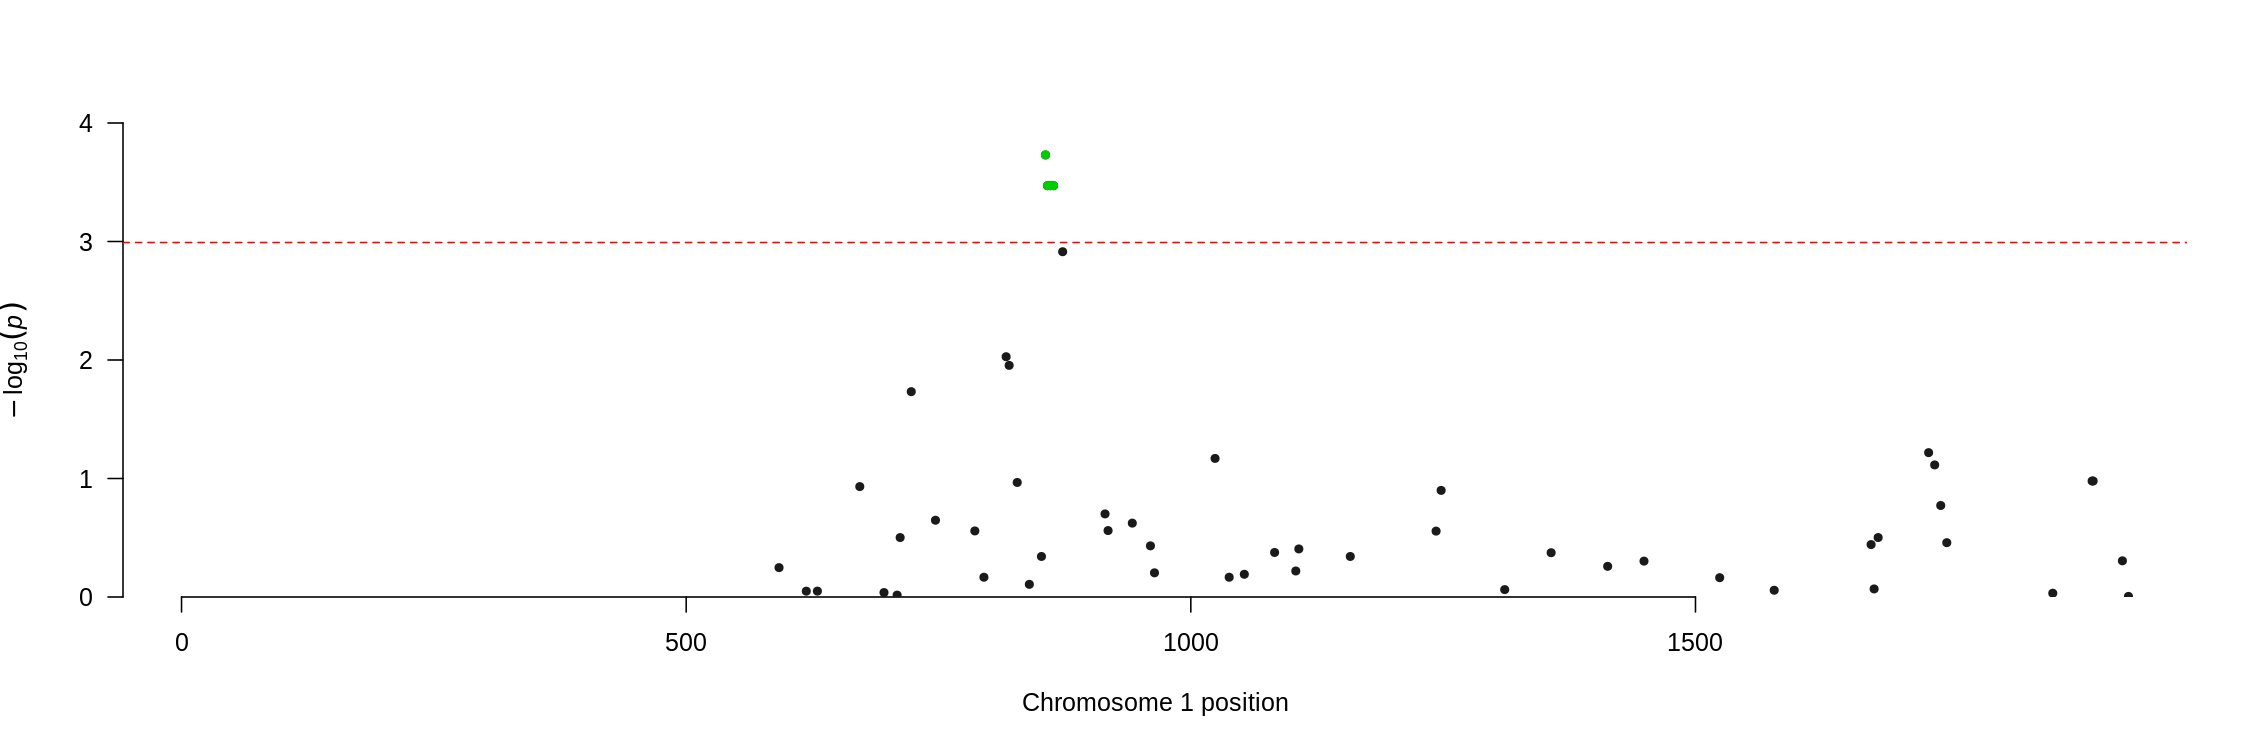

In [ ]:
library(qqman)


options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 150)
par(bg = "white")
manhattan(
    gono_gwas,
    chr="CHR",
    bp="BP",
    snp="SNP",
    p="lrt-pvalue",
    highlight = signif.snps
    ) +
    abline(h = p.value.cutoff, col = "red", lty = 2)

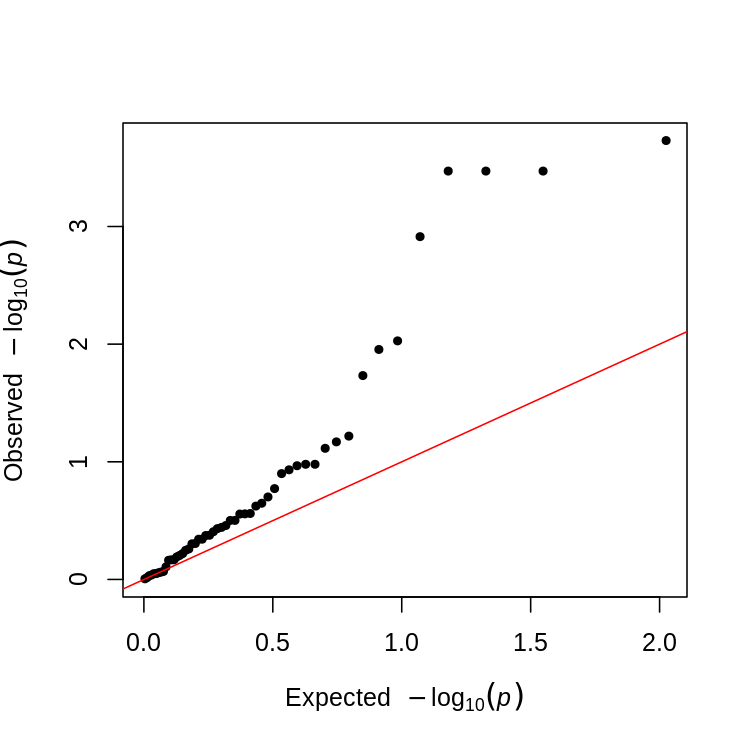

In [ ]:
library(qqman)


options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 150)
par(bg = "white")
qq(gono_gwas$"lrt-pvalue")

In [ ]:
chisq_vals <- qchisq(1 - gono_gwas$"lrt-pvalue", df = 1)
lambda <- median(chisq_vals) / qchisq(0.5, df = 1)
print(paste("Genomic inflation factor (λ):", round(lambda, 3)))

[1] "Genomic inflation factor (λ): 1.834"


## Pairwise distance matrix produced using mash

### Count the number of patterns to control for multiple testing

In [ ]:
python ~/workspace/pyseer/scripts/count_patterns.py mortality_SNP_patterns_mash.txt

Output:

Patterns:	33

Threshold:	5.10E-04

In [ ]:
library(data.table)


gono_gwas <- fread('~/workspace/genome_data/annotations/e_coli/gene_sequences/fhub_gene/mortality_SNPs_mash.txt', data.table = FALSE)
head(gono_gwas)

,variant,af,filter-pvalue,lrt-pvalue,beta,beta-std-err,intercept,PC1,PC2,notes
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,1_592_T_C,0.841,0.9620,0.242,-0.6550,0.581,-1.65,-0.644,0.933,NA
2,1_619_C_T,0.805,0.7870,0.264,-0.7530,0.712,-1.60,-0.788,0.980,NA
3,1_630_T_C,0.810,0.6580,0.547,-0.3760,0.640,-1.90,-0.507,0.932,NA
4,1_672_C_T,0.882,0.0661,0.968,0.0413,1.020,-2.24,-0.230,0.866,NA
5,1_696_G_T,0.740,0.8710,0.309,-0.7200,0.669,-1.67,-0.841,0.895,NA
6,1_709_C_T,0.779,0.7390,0.677,-0.4960,1.230,-1.81,-0.640,0.873,NA


In [ ]:
gono_gwas <- gono_gwas[order(gono_gwas$`lrt-pvalue`),]
gono_gwas <- gono_gwas[!grepl("bad-chisq", gono_gwas$notes),]

# threshold form running count_patterns in pyseer
sig_threshold <- 0.05/(42)
sig_threshold

[1] 0.001190476

In [ ]:
p_values <- gono_gwas$"lrt-pvalue"
alpha <- 0.05

# Use the p.adjust function with method=["bonferroni", "holm", "hochberg", "hommel", "BH", "BY"]
adjusted_p_values <- p.adjust(p_values, method = "BY")

significant <- adjusted_p_values < alpha

signif.snps <- gono_gwas$"SNP"[significant]

signif.snps

NULL

In [ ]:
p.value.cutoff = -log10(sig_threshold)
p.value.cutoff

[1] 2.924279

In [ ]:
sum(gono_gwas$`lrt-pvalue`<sig_threshold)

[1] 0

In [ ]:
sig_hits <- gono_gwas[gono_gwas$`lrt-pvalue`<sig_threshold,]
sig_hits

variant,af,filter-pvalue,lrt-pvalue,beta,beta-std-err,intercept,PC1,PC2,notes
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>


In [ ]:
signif.snps <- sig_hits$variant
signif.snps

character(0)

In [ ]:
library(dplyr)


gono_gwas <- gono_gwas %>% mutate(
    CHR = sapply(strsplit(variant, "_"), `[`, 1),
    BP  = sapply(strsplit(variant, "_"), `[`, 2),
    SNP = variant
)
gono_gwas$CHR = as.numeric(gono_gwas$CHR)
gono_gwas$BP = as.numeric(gono_gwas$BP)

head(gono_gwas)

,variant,af,filter-pvalue,lrt-pvalue,beta,beta-std-err,intercept,PC1,PC2,notes,CHR,BP,SNP
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<chr>
21,1_1024_G_A,0.8120,0.28700,0.00778,-1.070,0.395,-1.36,-0.869,1.060,NA,1,1024,1_1024_G_A
13,1_828_A_G,0.8560,0.42000,0.01290,-1.390,0.610,-1.04,-1.080,1.050,NA,1,828,1_828_A_G
11,1_817_T_C,0.0855,0.00790,0.02690,0.941,0.416,-2.30,-0.504,0.613,NA,1,817,1_817_T_C
12,1_820_T_C,0.0867,0.00937,0.03090,0.920,0.417,-2.30,-0.502,0.617,NA,1,820,1_820_T_C
9,1_786_A_G,0.1400,0.55500,0.04870,1.020,0.539,-2.36,-0.817,1.020,NA,1,786,1_786_A_G
7,1_723_A_T,0.8280,0.03630,0.05680,1.080,0.578,-3.11,0.354,0.546,NA,1,723,1_723_A_T


ERROR: Error in manhattan(gono_gwas, chr = "CHR", bp = "BP", snp = "SNP", p = "lrt-pvalue", : non-numeric argument to binary operator


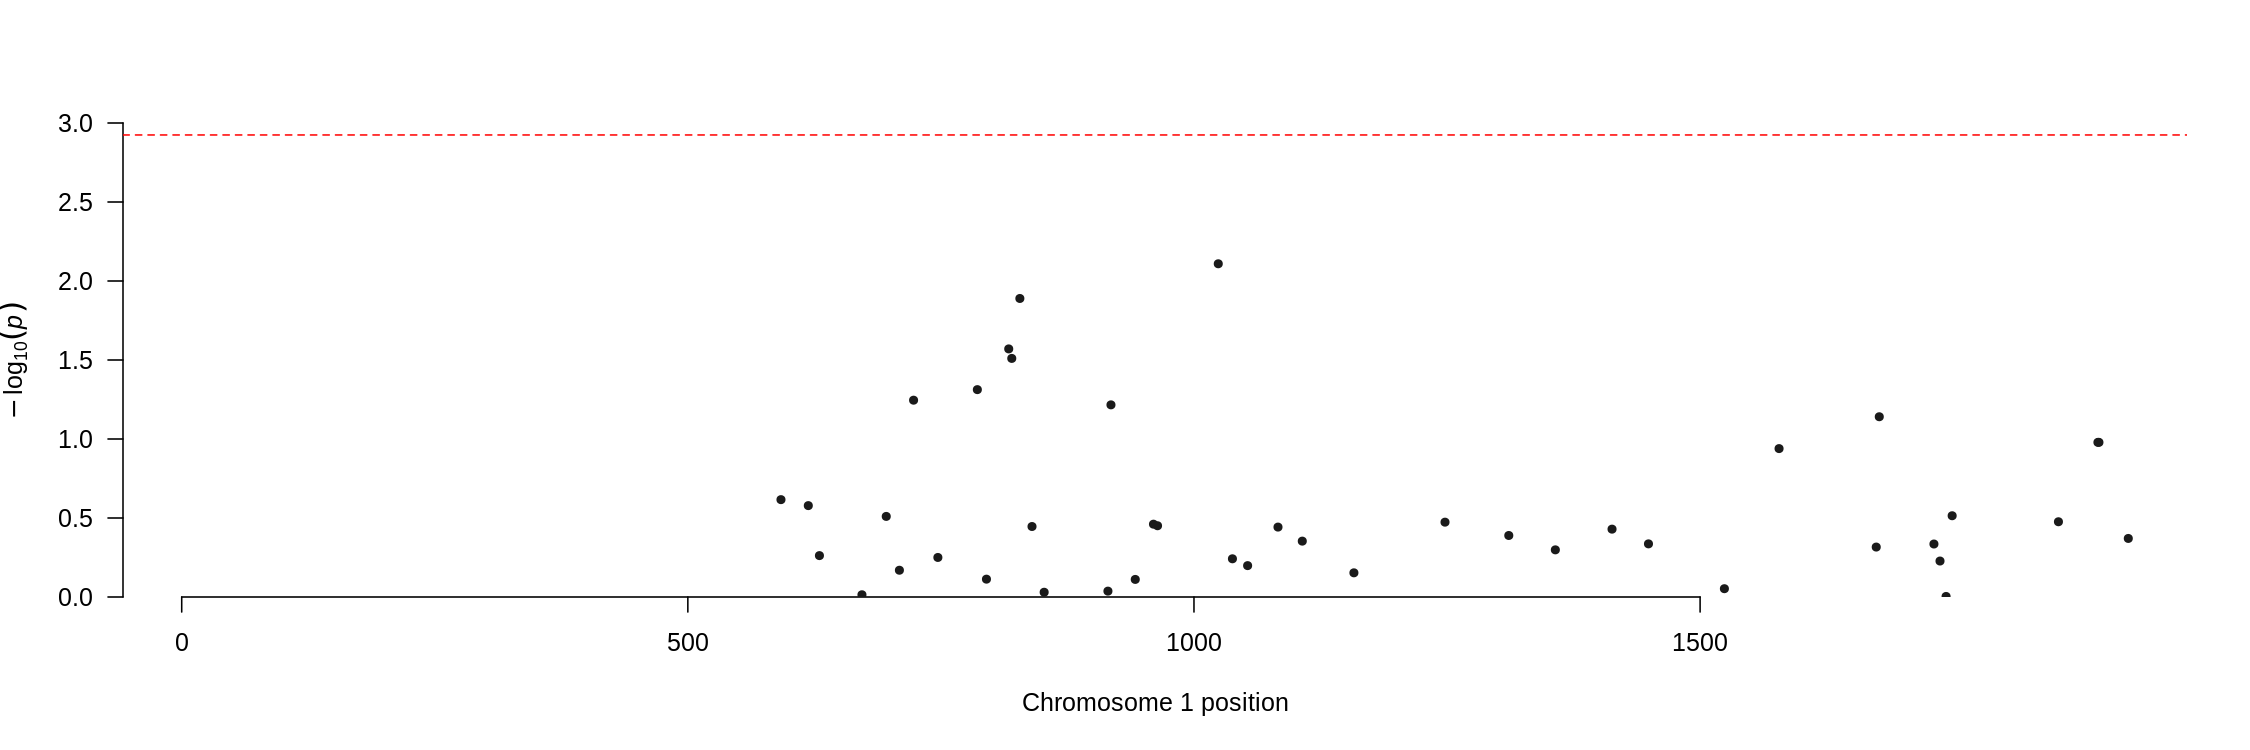

In [ ]:
library(qqman)


options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 150)
par(bg = "white")
manhattan(
    gono_gwas,
    chr="CHR",
    bp="BP",
    snp="SNP",
    p="lrt-pvalue",
    highlight = signif.snps
    ) +
    abline(h = p.value.cutoff, col = "red", lty = 2)

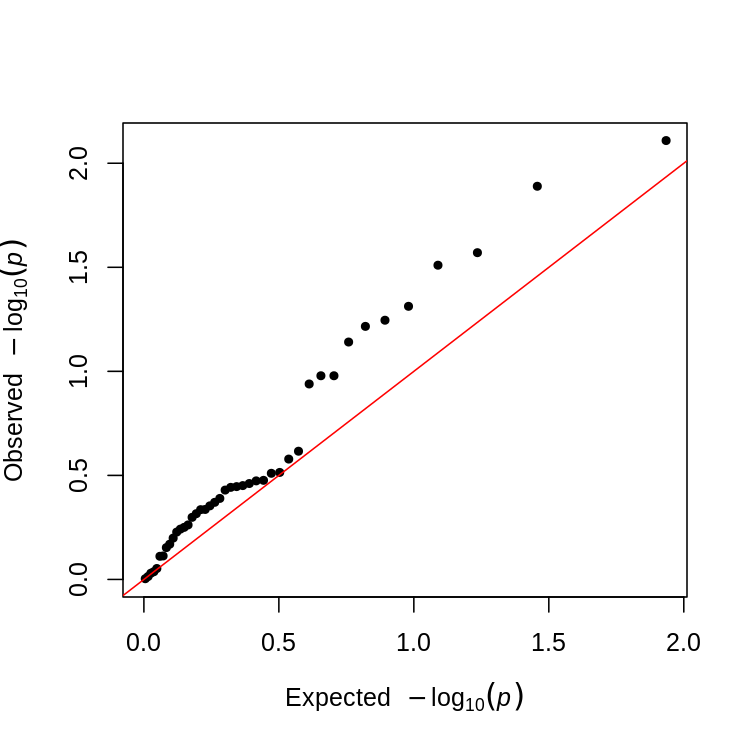

In [ ]:
library(qqman)


options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 150)
par(bg = "white")
qq(gono_gwas$"lrt-pvalue")

In [ ]:
chisq_vals <- qchisq(1 - gono_gwas$"lrt-pvalue", df = 1)
lambda <- median(chisq_vals) / qchisq(0.5, df = 1)
print(paste("Genomic inflation factor (λ):", round(lambda, 3)))

[1] "Genomic inflation factor (λ): 1.752"
